In [64]:
# Last update: 26 November 2018
# 
# This code create True MBSE dataset
# 
# Inputs: 
# 			None
# Outputs:
#			true.csv : List of true pair of nodes, 
#					   link type and target in format: [entity_a, entity_b, relation, target]
####################################################################################################

# Load libraries
import numpy as np
import pandas as pd

# Set parameters
Dimension = 100

# Targe values
true = 1

# Big nodes
RequerimentType = 0
TestCaseType = 100
SMT = 200
ProjectType = 300

#Relation type
instanceOf = 0
verifiedBy = 1
using = 2
belongsTo = 3

def Generate_True_Graph():
	''' Function to create all true links '''

	graph = []
	for requeriment in range(RequerimentType + 1, Dimension):
	    #[requirement[1-Dimension], RequirementType0, Relation = 0]
	    graph.append([requeriment, RequerimentType, instanceOf])
	    
	    #[requirement[1-Dimension], TestCase[1-Dimension], Relation = 1]
	    graph.append([requeriment, requeriment + TestCaseType, verifiedBy])
	    
	    #[requirement[1-Dimension], Proyect[1-Dimesion], Relation = 3]
	    graph.append([requeriment, requeriment + ProjectType, belongsTo])
	    
	for testcase in range(TestCaseType + 1, TestCaseType + Dimension):
	    #[testcase[1-Dimension], TestCaseType0, Relation = 0]
	    graph.append([testcase, TestCaseType, instanceOf])
	    
	    #[testcase[1-Dimension], SM[1-Dimension], Relation = 2]
	    graph.append([testcase, testcase + (SMT - Dimension), using])
	    
	    #[testcase[1-Dimension], TestCaseType0, Relation = 3]
	    graph.append([testcase, testcase + (ProjectType - Dimension), belongsTo])
	    
	for sm in range(SMT + 1, SMT + Dimension):
	    #[sm[1-Dimension], SMT, Relation = 0]
	    graph.append([sm, SMT, instanceOf])
	    
	    #[sm[1-Dimension], Proyect[1-Dimension], Relation = 3]
	    graph.append([sm, sm + Dimension, belongsTo])

	for project in range(ProjectType + 1, ProjectType + Dimension):
	    #[project[1-Dimension], ProjectType, Relation = 0]
	    graph.append([project, ProjectType, instanceOf])

	return graph


def main():
	''' Principal function '''

	# Call for Postive and Negative graph
	positive_graph = Generate_True_Graph()

	# Transform into a pandas dataframe
	true = pd.DataFrame(positive_graph, columns=['entity_a', 'entity_b', 'relation'])
	
	# Save data
	true.to_csv('./Data/true.csv',index = False)

	return 0

if __name__ == '__main__':
    main()

In [65]:
# Last update: 26 November
# 
# Author: Shaurya Shubham
# This code load the true graph and transform
# into train, valid and to_use datasets.
#
# inputs:
# true.csv

#
# outpus:
# train.csv
# valid.csv
# to_use.csv
# edges.csv
####################################################################################

# Load libraries
import pandas as pd # To handle dataframes
from sklearn.model_selection import train_test_split # to split the datasets


def Edges_Generation(true_graph):
    ''' Function to generate edges from the true graph '''

    edges = []
    for element in true_graph.iterrows():
        edges.append([element[1]['entity_a'],element[1]['entity_b'],element[1]['relation']])

    # Saving data
    df = pd.DataFrame(edges,columns=['entity_a', 'entity_b','relation'])
    df.to_csv('./Data/edges.csv',index= False)

def Generate_Train_Valid_Use(true_graph):
    ''' Function to generate train, valid and to_use datasets '''
    
    # Randomization of true
    true_graph = true_graph.sample(frac=1).reset_index(drop = True)
    
    # print some stats
    print 'Total unique entity_a : {}'.format(len(true_graph['entity_a'].unique().tolist()))
    print 'Total unique entity_b : {}'.format(len(true_graph['entity_b'].unique().tolist()))
    print 'Total unique entities : {}'.format(len(list(set(true_graph['entity_a'].unique().tolist() + true_graph['entity_b'].unique().tolist()))))
    print 'Total unique relations : {}'.format(len(true_graph['relation'].unique().tolist()))

	# Splitting true_graph into 3 pieces: true_train, true_valid, true_to_use
    train, valid_test = train_test_split(true_graph,test_size =0.7, random_state =1) # split the data into train and (test_vaidation)
    
    # print train dataset stats to see whether we are missing any entities or not
    print 'Total unique entity_a in train dataset : {}'.format(len(train['entity_a'].unique().tolist()))
    print 'Total unique entity_b in train dataset : {}'.format(len(train['entity_b'].unique().tolist()))
    print 'Total unique entities in train dataset : {}'.format(len(list(set(train['entity_a'].unique().tolist() + train['entity_b'].unique().tolist()))))
    
    unique_train_entities =list(set(train['entity_a'].unique().tolist() + train['entity_b'].unique().tolist()))
    unique_true_graph_entities = d =list(set(true_graph['entity_a'].unique().tolist() + true_graph['entity_b'].unique().tolist()))
    missing_entities_in_train =  set(unique_true_graph_entities) -set(unique_train_entities)
    
    train_extra = valid_test[valid_test.entity_b.isin(missing_entities_in_train)] # get the missing entities from entity_b to get embedding for all entities
    train = pd.concat([train,train_extra]) # making the complete train datset with all entities
    train = train.reset_index(drop = True)
    train.to_csv('./Data/train.csv',index=False)
    
    valid_test = valid_test[~valid_test.entity_b.isin(missing_entities_in_train)] # remove the train data which we added to train dataset by using train_extra
    
    valid,test = train_test_split(valid_test,test_size =0.75, random_state =1) # split the data into valid and test(to_use)
    valid.to_csv('./Data/valid.csv',index=False)
    test.to_csv('./Data/to_use.csv',index=False)


def main():
    ''' Principal function '''
    true_graph = pd.read_csv('./Data/true.csv')
    Generate_Train_Valid_Use(true_graph)
    Edges_Generation(true_graph)
    return 0

if __name__ == '__main__':
    main()

Total unique entity_a : 396
Total unique entity_b : 301
Total unique entities : 400
Total unique relations : 4
Total unique entity_a in train dataset : 205
Total unique entity_b in train dataset : 141
Total unique entities in train dataset : 282


In [66]:
k = pd.read_csv('./Data/train.csv')
k.shape

(393, 3)

In [68]:
# Last update: 26 November 2018
# 
# Author: Shaurya Shubham
# This code train the link prediction model by using HoLE and evaluate it
# 
# Inputs:
#     edges.csv : Dataset to create negative sample
#     train.csv : Dataset to train the model
# Outputs:
#     Statistics:
#        * About trainig
#        * About validation
#        * About the use of the model
#        * About Axel format
####################################################################################################

# Loading Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from numpy.fft import fft, ifft
import random
import itertools
import pandas as pd
import tqdm
from random import uniform

true_data = pd.read_csv('./Data/edges.csv')
Total_Entities = 400
Total_Relations = 4
Batch_Size = 2
Num_Neg_Sample = 40

# Function to create positive and negative samples
def positive(fact):

    #print fact
    entity_a, relation, entity_b = fact['entity_a'], fact['relation'], fact['entity_b']
    entity_a_id = Variable(torch.LongTensor([entity_a]))#.view(1, -1)
    entity_b_id = Variable(torch.LongTensor([entity_b]))#.view(1, -1)
    relation_id = Variable(torch.LongTensor([relation]))#.view(1, -1)
    target = Variable(torch.LongTensor([1])).view(1, -1)
    return [entity_a_id,entity_b_id,relation_id,target]
    
def negative(triplet,num_neg_triplets=1):
    #training triplets with either the head or tail replaced by a random entity (but not both at the same time)
    # Sample until we find an invalid fact
    corrupted_triplets = []
    num_neg_count = 0
    while num_neg_count < num_neg_triplets:
        i = uniform(-1, 1)
        if i < 0:
            while True:
                entity_a = random.randint(0, Total_Entities - 1)
                #relation = random.randint(0, Total_Relations - 1)
                #entity_b = random.randint(0, Total_Entities - 1)
                rule = {'entity_a':[entity_a],'entity_b':[triplet[1]],'relation':[triplet[2]]}
                if len(list(true_data.index[true_data.isin(rule).all(1)].values)) == 0:
                    if [[entity_a,triplet[1],triplet[2]]] not in corrupted_triplets:
                        target = Variable(torch.LongTensor([0])).view(1, -1)
                        corrupted_triplets.append([Variable(torch.LongTensor([entity_a])),triplet[1],triplet[2],target])
                        num_neg_count+=1
                        break
        if i > 0:
            while True:
                entity_b = random.randint(0, Total_Entities - 1)
                #relation = random.randint(0, Total_Relations - 1)
                #entity_b = random.randint(0, Total_Entities - 1)
                rule = {'entity_a':[triplet[0]],'entity_b':[entity_b],'relation':[triplet[2]]}
                if len(list(true_data.index[true_data.isin(rule).all(1)].values)) == 0:
                    if [[triplet[0],entity_b,triplet[2]]] not in corrupted_triplets:
                        target = Variable(torch.LongTensor([0])).view(1, -1)
                        corrupted_triplets.append([triplet[0],Variable(torch.LongTensor([entity_b])),triplet[2],target])
                        num_neg_count+=1
                        break

    return corrupted_triplets

In [69]:
# Custom Dataloader
class CustomDataset():
    
    def __init__(self,filepath):
        self.data = pd.read_csv(filepath, delimiter=',')
        self.data.dropna(inplace=True)
        
    def __getitem__(self,index):
        sample = {}
        sample['pos'] = positive(self.data.iloc[index])
        #sample['neg'] = negative()
        sample['neg'] = negative(sample['pos'],Num_Neg_Sample)
        #for i in range(Num_Neg_Sample):
        #    sample['neg'].append(negative())
        #sample['neg'] = list(itertools.chain.from_iterable(sample['neg']))
        samples = [[sample['pos']],sample['neg']]
        samples = list(itertools.chain.from_iterable(samples))
        return samples
        
    def __len__(self):
        return (self.data.shape[0])

hole_data = CustomDataset('./Data/train.csv')

# Collage function to handle lists in dataloader
def my_collate(batch):
    #print len(batch)
    batch = list(itertools.chain.from_iterable(batch))
    data = [item for item in batch]
    return data

dataloader = DataLoader(hole_data, batch_size=Batch_Size,shuffle=False,collate_fn=my_collate)

In [70]:
hole_data[0]

[[tensor([25]), tensor([125]), tensor([1]), tensor([[1]])],
 [tensor([25]), tensor([306]), tensor([1]), tensor([[0]])],
 [tensor([153]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([17]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([25]), tensor([180]), tensor([1]), tensor([[0]])],
 [tensor([25]), tensor([5]), tensor([1]), tensor([[0]])],
 [tensor([182]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([140]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([3]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([144]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([25]), tensor([111]), tensor([1]), tensor([[0]])],
 [tensor([91]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([278]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([25]), tensor([153]), tensor([1]), tensor([[0]])],
 [tensor([25]), tensor([12]), tensor([1]), tensor([[0]])],
 [tensor([268]), tensor([125]), tensor([1]), tensor([[0]])],
 [tensor([297]), tensor([125]), tensor

In [71]:
for d in dataloader:
    print len(d)
    #print "--"
    break

82


In [143]:
## Holographic Embedding Implemetations

class HoLE(nn.Module):
    
    def __init__(self,num_entity,num_rel, emb_dim):
        super(HoLE,self).__init__()
        self.ent_embeddings=nn.Embedding(num_entity,emb_dim)
        self.rel_embeddings=nn.Embedding(num_rel,emb_dim)
        self.init_weights()
    
    def init_weights(self):
        nn.init.xavier_uniform_(self.ent_embeddings.weight.data)
        nn.init.xavier_uniform_(self.rel_embeddings.weight.data)
    
    # Circular correlation
    def ccorr(self, a, b):
        #print a
        #print a.size()
        k = torch.rfft(a,1,onesided=False)
        t = torch.rfft(b,1,onesided=False)
        k = k *torch.FloatTensor([1,-1])
        real = (k[:,:,0] * t[:,:,0]) - (k[:,:,1] * t[:,:,1])
        imag = (k[:,:,0] * t[:,:,1]) + (k[:,:,1] * t[:,:,0])
        a=[]
        for i,j in zip(real,imag):
            a.append(i)
            a.append(j)
        a =torch.stack(a,dim=-1)
        #print a.size()
        t = torch.split(a,2,dim=1)
        t = torch.stack(t,dim=0)
        #print t.size()
        v = torch.ifft(t,1)
        #print v.size()
        return v[:,:,0]
    
    def score(self,head, tail, rel):
        entity_mention = self.ccorr(head, tail)
        relation_norm = rel.norm(p=2, dim=1, keepdim=True)
        relation_mention = rel.div(relation_norm.expand_as(rel))
        #print relation_mention.size()
        #print entity_mention.size()
        _sum = torch.sum(relation_mention * entity_mention,dim=1)
        #print _sum.size()
        return torch.sigmoid(_sum)
    
    def forward(self,x):
        #x = Variable(torch.LongTensor(x))
        #print x
        #print type(x)
        entity_a, entity_b, relation = x[:,0].view(-1, 1),x[:,1].view(-1, 1),x[:,2].view(-1, 1)
        s = self.ent_embeddings(entity_a)
        #print entity_b
        o = self.ent_embeddings(entity_b)
        r = self.rel_embeddings(relation)
        #print s.view(-1,10).size()
        #print o.size()
        #print r.size()
        out = self.score(s.view(-1,emb_dim),o.view(-1,emb_dim),r.view(-1,emb_dim))
        return out

## Loading the model
num_entity = Total_Entities
num_relation = Total_Relations
emb_dim =5

hole = HoLE(num_entity,num_relation,emb_dim)

use_gpu = torch.cuda.is_available()
if use_gpu:
    hole = hole.cuda()
    print ('USE GPU')
else:
    print ('USE CPU')
print hole

# Total number of trainable parameters
total_params = sum(p.numel() for p in hole.parameters() if p.requires_grad)
print("Total number of trainable parameters : {}" .format(total_params))

# Criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(hole.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(hole.parameters(), lr=0.001)

# train and validation losses
train_losses = []
valid_losses = []

# Training of model
num_epoch = 40

USE CPU
HoLE(
  (ent_embeddings): Embedding(400, 5)
  (rel_embeddings): Embedding(4, 5)
)
Total number of trainable parameters : 2020


In [144]:
for epoch in range( num_epoch):
    
    print('Epoch {}/{}'.format(epoch, num_epoch- 1))
    print('-' * 10)
    
    # Each epoch has a training 
    hole.train() # Set model to training mode
    
    running_loss = 0.0
    # Iterate over data.
    for idx,x in enumerate(dataloader):
        x = Variable(torch.LongTensor(x))
        if use_gpu:
            x  = x.cuda()

        #print x.size()
        outputs = hole(x) # Forward pass: compute the output class given a image
        target = x[:,3].view(-1, 1)
        target = target.type(torch.FloatTensor)
        optimizer.zero_grad() # clear gradients for next train
        outputs = outputs.view(-1,1)
        loss = criterion(outputs,target) # Compute the loss: difference between the output class and the pre-given label
        loss.backward() # backpropagation, compute gradients
        optimizer.step() # apply gradients  and update the weights of hidden nodes

        running_loss += loss.data * outputs.shape[0]

        #if phase == 'train':
        #    if (i+1) % 100 == 0 :
        #        print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, i+1, data_lengths[phase]//64, loss.data))

    epoch_loss = running_loss/float((train_data.shape[0]*Num_Neg_Sample)+train_data.shape[0]) 
    train_losses.append(epoch_loss)
    print('Epoch [{}/{}]{} Loss: {:.4f}'.format(epoch+1, num_epoch,'train', epoch_loss))
    

Epoch 0/39
----------
Epoch [1/40]train Loss: 0.6929
Epoch 1/39
----------
Epoch [2/40]train Loss: 0.6894
Epoch 2/39
----------
Epoch [3/40]train Loss: 0.6690
Epoch 3/39
----------
Epoch [4/40]train Loss: 0.6221
Epoch 4/39
----------
Epoch [5/40]train Loss: 0.5564
Epoch 5/39
----------
Epoch [6/40]train Loss: 0.4814
Epoch 6/39
----------
Epoch [7/40]train Loss: 0.4096
Epoch 7/39
----------
Epoch [8/40]train Loss: 0.3464
Epoch 8/39
----------
Epoch [9/40]train Loss: 0.2923
Epoch 9/39
----------
Epoch [10/40]train Loss: 0.2503
Epoch 10/39
----------
Epoch [11/40]train Loss: 0.2160
Epoch 11/39
----------
Epoch [12/40]train Loss: 0.1892
Epoch 12/39
----------
Epoch [13/40]train Loss: 0.1697
Epoch 13/39
----------
Epoch [14/40]train Loss: 0.1543
Epoch 14/39
----------
Epoch [15/40]train Loss: 0.1424
Epoch 15/39
----------
Epoch [16/40]train Loss: 0.1333
Epoch 16/39
----------
Epoch [17/40]train Loss: 0.1269
Epoch 17/39
----------
Epoch [18/40]train Loss: 0.1222
Epoch 18/39
----------
Epoch 

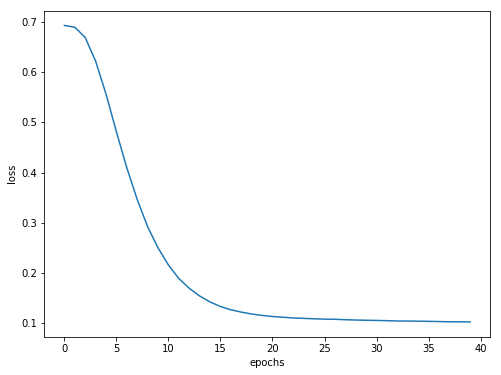

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6),)
plt.plot(train_losses)
plt.xlabel('epochs')
plt.ylabel('loss');

In [139]:
# prediction function
def hole_prediction(model,fact):
    model.eval()
    i = fact['entity_a']
    j = fact['entity_b']
    r = fact['relation']
    xt = [torch.LongTensor([i]),torch.LongTensor([j]),torch.LongTensor([r])]
    xt = Variable(torch.LongTensor(xt))
    xt = xt.view(1,-1)
    pred_score = hole(xt)
    if pred_score.data>0.5:
        return pred_score.data, 1
    else:
        return pred_score.data, 0

## Training Data Stats

train_data =  pd.read_csv('./Data/train.csv', delimiter=',')
train_data.dropna(inplace=True)
train_data['prediction'] = ''
# Calculating train data stats
for idx,dat in  tqdm.tqdm_notebook(enumerate(train_data.iterrows())):
    train_data['prediction'].iloc[idx],_ = hole_prediction(hole,dat[1])

A Jupyter Widget

In [140]:
train_data

,entity_a,entity_b,relation,prediction
0,25,125,1,[tensor(0.0368)]
1,187,100,0,[tensor(0.0405)]
2,226,326,3,[tensor(0.0293)]
3,39,339,3,[tensor(0.0377)]
4,198,298,2,[tensor(0.0419)]
5,165,265,2,[tensor(0.0321)]
6,314,300,0,[tensor(0.0284)]
7,101,201,2,[tensor(0.0342)]
8,33,133,1,[tensor(0.0316)]
9,117,317,3,[tensor(0.0444)]


In [147]:
# prediction function
def hole_prediction(model,fact):
    model.eval()
    i = fact['entity_a']
    j = fact['entity_b']
    score = -1
    for k in range(4):
        xt = [torch.LongTensor([i]),torch.LongTensor([j]),torch.LongTensor([k])]
        xt = Variable(torch.LongTensor(xt))
        xt = xt.view(1,-1)
        #print xt.size()
        #print "predicting"
        pred_score = hole(xt)
        #print pred_score
        if score < pred_score.data:
            prediction = k
            score = pred_score.data
    return score, prediction

## Training Data Stats

train_data =  pd.read_csv('./Data/train.csv', delimiter=',')
train_data.dropna(inplace=True)
train_data['prediction'] = ''
# Calculating train data stats
for idx,dat in  tqdm.tqdm_notebook(enumerate(train_data.iterrows())):
    _,train_data['prediction'].iloc[idx] = hole_prediction(hole,dat[1])

acc_count = (train_data['prediction'] == train_data['relation']).sum()
acc = float(acc_count)/train_data.shape[0]

# Printing results
print("\n- - - - - - - - - - - - - STATISTICS ON TRAINING DATASET - - - - - - - - - - - - - - \n")
print("Total number of Green links in training dataset : {} ".format(train_data.shape[0]))
print(" Number of Green predicted correctly: {}".format(acc_count))
print(" Accuracy of Green predicted correctly: {}".format(acc))

## Validation Data Stats

valid_data =  pd.read_csv('./Data/valid.csv', delimiter=',')
valid_data.dropna(inplace=True)
valid_data['prediction'] = ''
# Calculating train data stats
for idx,dat in  tqdm.tqdm_notebook(enumerate(valid_data.iterrows())):
    _,valid_data['prediction'].iloc[idx] = hole_prediction(hole,dat[1])

acc_count = (valid_data['prediction'] == valid_data['relation']).sum()
acc = float(acc_count)/valid_data.shape[0]

# Printing results
print("\n- - - - - - - - - - - - - STATISTICS ON VALIDATION DATASET - - - - - - - - - - - - - - \n")
print("Total number of Green links in training dataset : {} ".format(valid_data.shape[0]))
print(" Number of Green predicted correctly: {}".format(acc_count))
print(" Accuracy of Green predicted correctly: {}".format(acc))

## To_use Data Stats

test_data =  pd.read_csv('./Data/to_use.csv', delimiter=',')
test_data.dropna(inplace=True)
test_data['prediction'] = ''
# Calculating train data stats
for idx,dat in  tqdm.tqdm_notebook(enumerate(test_data.iterrows())):
    _,test_data['prediction'].iloc[idx] = hole_prediction(hole,dat[1])

acc_count = (test_data['prediction'] == test_data['relation']).sum()
acc = float(acc_count)/test_data.shape[0]

# Printing results
print("\n- - - - - - - - - - - - - STATISTICS ON TO_USE DATASET - - - - - - - - - - - - - - \n")
print("Total number of Green links in training dataset : {} ".format(test_data.shape[0]))
print(" Number of Green predicted correctly: {}".format(acc_count))
print(" Accuracy of Green predicted correctly: {}".format(acc))

A Jupyter Widget



- - - - - - - - - - - - - STATISTICS ON TRAINING DATASET - - - - - - - - - - - - - - 

Total number of Green links in training dataset : 393 
 Number of Green predicted correctly: 77
 Accuracy of Green predicted correctly: 0.195928753181


A Jupyter Widget



- - - - - - - - - - - - - STATISTICS ON VALIDATION DATASET - - - - - - - - - - - - - - 

Total number of Green links in training dataset : 124 
 Number of Green predicted correctly: 12
 Accuracy of Green predicted correctly: 0.0967741935484


A Jupyter Widget



- - - - - - - - - - - - - STATISTICS ON TO_USE DATASET - - - - - - - - - - - - - - 

Total number of Green links in training dataset : 374 
 Number of Green predicted correctly: 27
 Accuracy of Green predicted correctly: 0.072192513369
